###  Face Recognition Application


----

### Phase 01: Face detection

In [ ]:
#!pip install facenet_pytorch

In [3]:
#!pip install mtcnn
import os
from PIL import Image
from facenet_pytorch import MTCNN
import torch
from torchvision.transforms.functional import to_pil_image

import os
#import cv2
import numpy as np
from tqdm import tqdm
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image 
import math 
from torchvision.transforms.functional import to_pil_image

In [29]:
import os
from PIL import Image
from facenet_pytorch import MTCNN
import torch
from torchvision.transforms.functional import to_pil_image

import os
#import cv2
import numpy as np
from tqdm import tqdm
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image 
import math 
from torchvision.transforms.functional import to_pil_image

#data_dir = './samples/train'
#output_dir = './samples/train_cropped'

def process_dataset(data_dir, output_dir):

    os.makedirs(output_dir, exist_ok=True)

    mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

    for person_name in os.listdir(data_dir):
        person_dir = os.path.join(data_dir, person_name)
        if os.path.isdir(person_dir):
            output_person_dir = os.path.join(output_dir, person_name)
            os.makedirs(output_person_dir, exist_ok=True)

            for image_name in os.listdir(person_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(person_dir, image_name)
                    image = Image.open(image_path).convert('RGB')  # Convert to RGB
                    results = mtcnn.detect(image)

                    if results is not None:
                        delimit, logit = results
                        
                        if delimit is not None and logit is not None:
                            best_logit = max(logit)
                            indices = [i for i, x in enumerate(logit) if x == best_logit]
                            best_face = [delimit[index] for index in indices]                            
                            if best_face is not None:
                                    #x, y, w, h = (best_face[0], best_face[1], best_face[2], best_face[3])
                                    x, y, w, h = (best_face[0][0], best_face[0][1], best_face[0][2], best_face[0][3])
                                    cropped_face = image.crop((x, y,w, h))
                                    face_path = os.path.join(output_person_dir, f"face_{image_name}")

                                # Save the cropped face image
                                    cropped_face.save(face_path)
                        else: ('face not found:{image_path}')
    print("Face detection and cropping completed.")

In [ ]:
dataset_folder = r'curated_data\train'
output_folder = r'Final_project\mtcnn_processed_images'
os.makedirs(output_folder, exist_ok=True)
process_dataset(dataset_folder, output_folder)

In [ ]:
dataset_folder = r'\curated_data\val'
output_folder = r'\data\mtcnn_test'
os.makedirs(output_folder, exist_ok=True)
process_dataset(dataset_folder, output_folder)

Some manual clean up has been done on the testing and training data since there were faces that were not capture correclty

### Phase 02: Face recognition 

Downloading the packages needed 

In [ ]:
#!pip install facenet-pytorch


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


from facenet_pytorch import MTCNN,  InceptionResnetV1, fixed_image_standardization, training
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import models
np.random.seed(72)
torch.manual_seed(72)

In [ ]:
from PIL import Image 
from IPython import display

img = Image.open(r"D:\Person\face_Picture 1.jpg")

display.display(img)


In [3]:
from torchvision import transforms
train_transform = transforms.Compose([
   transforms.Resize((160,160)),
   transforms.RandomAffine(degrees=15, translate=[0.1, 0.1]), 
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
val_transform = transforms.Compose([
   transforms.Resize((160,160)),
   transforms.RandomAffine(degrees=15, translate=[0.1, 0.1]), 
    transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

In [5]:
from torchvision import datasets 
train_dataset = datasets.ImageFolder(root=r'data\Final_project\mtcnn_processed_images', transform=train_transform)
val_dataset = datasets.ImageFolder(root=r'data\Final_project\mtcnn_test', transform=val_transform)


In [ ]:
# Extract class names from the dataset
class_names = train_dataset.classes
class_names


In [ ]:

# Create a dictionary to map class indices to class labels
class_idx_to_label = {i: class_name for i, class_name in enumerate(class_names)}
class_idx_to_label

In [13]:
class_names_test = val_dataset.classes

In [14]:
#| label: code-1
len(train_dataset) ,len(val_dataset),

(430, 46)

In [15]:
#| label: code-2
train_dataset, test_dataset = random_split(train_dataset,[407, 23])
len(train_dataset), len(test_dataset)

(407, 23)

In [16]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8)
test_loader = DataLoader(dataset=test_dataset, batch_size=8)

In [17]:
device='cpu'

Face Net 

In [19]:
#help(InceptionResnetV1)

In [66]:

facenet_model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
facenet_model

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [104]:
class FaceNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        facenet_model = InceptionResnetV1(pretrained='vggface2',classify=True, num_classes=46).eval().to(device)
        base_facenet = list(facenet_model.children())[:-5]
        self.features = nn.Sequential(*base_facenet)
        
        self.avgpool_1a = facenet_model.avgpool_1a
        self.dropout = facenet_model.dropout
        self.last_linear = facenet_model.last_linear
        self.last_bn = facenet_model.last_bn
        

        self.lightweight_network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 46),
            #nn.ReLU(),
            #nn.SiLU(),
            #nn.Dropout(0.3),
            #nn.Linear(120, 46),

        )

    def forward(self, x):
        out = self.features(x)
        out = self.avgpool_1a(out)
        out = self.dropout(out)
        out = torch.flatten(out, 1)
        out = self.last_linear(out)
        out = self.last_bn(out)
        out = self.lightweight_network(out)
        
        
        return out

In [105]:
#| label: code-3
tmpModel = FaceNetModel().to(device)
tmpImg, _= next(iter(train_loader))
tmpImg = tmpImg.to(device)
tmpOut = tmpModel(tmpImg)
tmpOut.shape

torch.Size([8, 46])

In [88]:
model = FaceNetModel().to(device)

for params in model.features.parameters():
    params.requires_grad = False

print("Done")

Done


In [89]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [109]:
torch.cuda.empty_cache() 
#import torch.optim.adabound as AdaBound
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F

#conf_matrix_val = torch.zeros(len(class_names), len(class_names))

train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 0.001
n_epochs = 4

loss_fn = nn.CrossEntropyLoss()
#optimizer = AdaBound(model.parameters(), lr=lr, weight_decay=5e-4)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader:  
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch)
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        #scheduler.step()
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        softmax_probs = F.softmax(y_logits, dim=1)
        print("Softmax Probabilities:", softmax_probs)
        #conf_matrix_tr += confusion_matrix(y_batch.cpu().numpy(), y_pred.cpu().numpy())
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in test_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
            
        #conf_matrix_val += confusion_matrix(y_val.cpu().numpy(), y_pred.cpu().numpy(),labels=range(46))
            
    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(test_loader)
    validation_accs.append(validation_acc)
    
    
    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")
    
      
# Plot confusion matrices
#fig, axes = plt.subplots(1, 1, figsize=(16, 8))
#sns.heatmap(conf_matrix_val, annot=True, fmt='g', ax=axes[1], cmap="crest")
#axes.set_title("Validation Confusion Matrix")
#plt.show()

Softmax Probabilities: tensor([[1.2754e-08, 1.7302e-05, 2.1025e-06, 1.1066e-05, 4.9797e-07, 2.2064e-04,
         1.1673e-08, 3.6607e-06, 3.6444e-06, 2.2827e-05, 1.3522e-06, 2.0432e-06,
         4.2027e-06, 1.0059e-05, 6.7353e-08, 1.8910e-07, 1.7496e-07, 1.4959e-06,
         1.3799e-07, 3.2439e-07, 2.0985e-05, 1.3519e-05, 3.0841e-08, 5.0447e-06,
         2.7595e-06, 1.0278e-05, 9.1386e-06, 4.1769e-08, 2.9599e-07, 2.5808e-07,
         1.2406e-05, 2.8771e-08, 4.6234e-06, 1.3735e-06, 9.9942e-01, 1.7646e-06,
         1.8506e-06, 1.3730e-06, 3.4641e-07, 1.5642e-04, 3.3641e-06, 6.2478e-06,
         4.4526e-07, 2.4848e-09, 6.9112e-08, 2.3127e-05],
        [1.5493e-03, 4.7010e-04, 1.8865e-03, 2.2338e-03, 1.4901e-03, 5.2201e-03,
         2.4182e-04, 2.4271e-01, 4.7259e-04, 3.1900e-03, 1.0600e-04, 3.2643e-03,
         7.0718e-03, 2.3476e-03, 8.8625e-03, 1.5401e-03, 8.7697e-04, 1.3762e-02,
         5.1221e-02, 1.0409e-02, 4.8483e-05, 2.5367e-03, 6.0574e-02, 7.0664e-03,
         1.8170e-02, 1.3965e

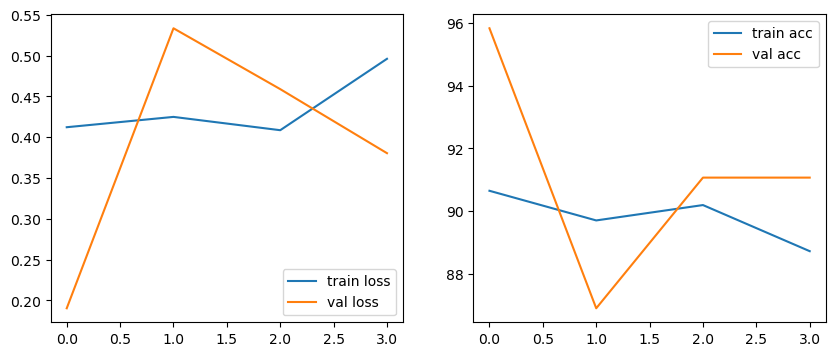

In [110]:
#| label: code-4
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

Checking the model

In [91]:
transform = transforms.Compose([
   transforms.Resize((299,299)),
   transforms.RandomAffine(degrees=15, translate=[0.1, 0.1]), # Optional: Small translation to simulate off-center subjects
    transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(),
   transforms.ToTensor(),
   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

]) 

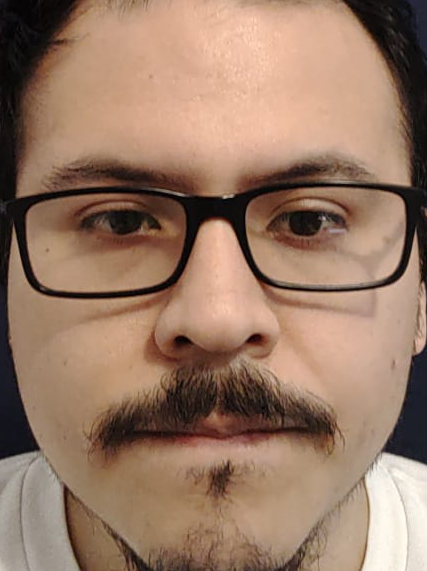

['JeanLuis']

In [113]:
#| label: code-5
from PIL import Image
from facenet_pytorch import MTCNN 

image_path = r"C:\WhatsApp Image.jpeg"

mtcnn = MTCNN()
pil_image = Image.open(image_path).convert('RGB')
    
box,_ = mtcnn.detect(pil_image)

face = pil_image.crop((box[0][0], box[0][1], box[0][2], box[0][3]))

display.display(face)
transformed_image = transform(face)
image_tensor = transformed_image.to(device)
image_tensor = image_tensor.unsqueeze(0)
model.eval()
y_logits = model(image_tensor)

y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_pred_labels = [class_idx_to_label[idx.item()] for idx in y_pred]
y_pred_labels


#display.display(image)

In [102]:
def predict_frame(frame, model, transform, device):

    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    mtcnn = MTCNN(keep_all=True, device='cuda' if torch.cuda.is_available() else 'cpu')

    boxes, _ = mtcnn.detect(pil_image)

    if boxes is None:
        return None, None

    predictions = []

    for box in boxes:

        face = pil_image.crop((box[0], box[1], box[2], box[3]))

        face = transform(face).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(face)
            _, predicted = torch.max(outputs.data, 1)
            predictions.append(predicted.item())

    return boxes, predictions

In [112]:
# Initialize webcam
import cv2
import torch
from PIL import Image
from facenet_pytorch import MTCNN

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    boxes, predictions = predict_frame(frame, model, transform, device)

    if boxes is not None:
        for box, predicted_class_idx in zip(boxes, predictions):

            predicted_class_name =   class_idx_to_label[predicted_class_idx]

            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
            cv2.putText(frame, predicted_class_name, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 1)

    cv2.imshow('Video Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()

cv2.destroyAllWindows() 
mtcnn = MTCNN(keep_all=True, device="cpu")



Resnet-50 Neural Network

In [ ]:
class ResNet50Model(nn.Module):
    def __init__(self):
        super().__init__()
        resnet_model = models.resnet50(weights="DEFAULT")
        base_ = list(resnet_model.children())[:-1]
        self.features = nn.Sequential(*base_)
        
        self.fc = nn.Sequential(
                nn.Flatten(), # 512x7x7 --> 25088x1
                nn.Linear(2048,500),
                nn.Linear(500,46)
        )
    
    def forward(self, x):
        out = self.features(x)
        out = self.fc(out)
        
        return out
    
tmpModel = ResNet50Model().to(device)
tmpImg, _= next(iter(train_loader))
tmpImg = tmpImg.to(device)
tmpOut = tmpModel(tmpImg)
tmpOut.shape

In [ ]:
model = ResNet50Model().to(device)

for params in model.features.parameters():
    params.requires_grad = False

print("Done")

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 0.01
n_epochs = 1

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_logits = model(x_batch) # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in train_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device)

            y_logits = model(x_val)
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(train_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(train_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

---

# NOTEBOOK OF THE RESULTS

+ Images Transormed
+ Model Resnet50
+ UnFrozen weights
+ lr =0.01
+ optimizer Adam


Epoch: 0 | Loss: 12.39142, Accuracy: 14.10% | val loss: 6.99946, val acc: 21.03%

+ Images just reshaped
+ Model Resnet50
+ Frozen weights
+ lr =0.01
+ optimizer Adam


Epoch: 0 | Loss: 4.77239, Accuracy: 2.56% | val loss: 314130.94712, val acc: 0.77%

+ Images just reshaped
+ Model Resnet50
+ UnFrozen weights
+ lr =0.01
+ optimizer Adam


Epoch: 0 | Loss: 5.50094, Accuracy: 13.59% | val loss: 5.22778, val acc: 23.85%

+ Images just reshaped
+ Model Resnet50
+ UnFrozen weights
+ lr =0.001
+ optimizer Adam


Epoch: 0 | Loss: 3.81925, Accuracy: 4.87% | val loss: 3.48758, val acc: 16.67%

+ Images just reshaped
+ Model ResnetV1
+ Frozen weights
+ lr =0.01
+ optimizer SGD


Epoch: 0 | Loss: 1.59268, Accuracy: 71.15% | val loss: 2.40955, val acc: 38.89%

+ Images just reshaped
+ Model ResnetV1
+ UnFrozen weights
+ lr =0.01
+ optimizer SGD


Epoch: 0 | Loss: 3.80450, Accuracy: 5.05% | val loss: 3.75325, val acc: 7.12%

+ Images just reshaped
+ Model ResnetV1
+ UnFrozen weights
+ lr =0.01
+ optimizer Adam


Epoch: 0 | Loss: 5.94543, Accuracy: 31.25% | val loss: 6.56866, val acc: 24.48%

+ Model ResnetV1
+ UnFrozen weights
+ lr =0.005
+ Penultima Linea 146
+ optimizer AdamW

Epoch: 0 | Loss: 4.03570, Accuracy: 12.16% | val loss: 3.50707, val acc: 18.75%
Epoch: 1 | Loss: 2.93324, Accuracy: 27.70% | val loss: 2.61983, val acc: 36.11%
Epoch: 2 | Loss: 2.40145, Accuracy: 34.12% | val loss: 2.72687, val acc: 40.28%

+ 300 neural nets

Epoch: 0 | Loss: 4.74045, Accuracy: 9.80% | val loss: 3.91102, val acc: 22.92%
Epoch: 1 | Loss: 3.34896, Accuracy: 27.70% | val loss: 2.57608, val acc: 45.83%
Epoch: 2 | Loss: 2.47652, Accuracy: 38.85% | val loss: 2.10100, val acc: 52.78%
